In [ ]:
from IPython.display import clear_output

!pip install ipython-autotime
!apt-get update
!apt install ghostscript python3-tk
!apt-get install libmagickwand-dev
!pip install pdfplumber
!pip install pdf2image
!apt-get install poppler-utils

clear_output()  

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

import pandas as pd
import tqdm
# from tabulate import tabulate
import pdfplumber
import glob
import os
import re
from pdf2image import convert_from_path
from functools import reduce
%load_ext autotime

time: 372 µs (started: 2022-12-01 00:50:13 +00:00)


### Table detection using pdfplumber

In [ ]:
sheet_id = "1ixtNKdaaFW8XNROXMWWveuCxHPErju5UUgwDw5PjM_w"
sheet_name = "Files_and_Type"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"

df = pd.read_csv(url)
all_subpaths = list(df['Full Path'])

all_paths = []
for path in all_subpaths:
  t = glob.glob(f'/content/drive/MyDrive/OCR NLP Stage 2/FSSC/Documents/**/{path}', recursive=True)
  all_paths += t

time: 7.03 s (started: 2022-12-01 00:50:13 +00:00)


In [ ]:
from statistics import mode
from scipy import stats
from collections import Counter
from collections.abc import Iterable

def keep_visible_lines(mode_value):
    """
    If the object is a ``rect`` type, keep it only if the lines are visible.

    A visible line is the one having ``non_stroking_color`` as 0.
    """
    def process(obj):
      if obj['object_type'] == 'rect':
          v = tuple(obj['non_stroking_color']) if isinstance(obj['non_stroking_color'], Iterable) else obj['non_stroking_color']
          return v in mode_value
      return True
    return process
      

time: 827 ms (started: 2022-11-30 09:27:46 +00:00)


In [ ]:
pdf_path = all_paths[0]

time: 1.95 ms (started: 2022-11-30 09:27:47 +00:00)


[0.502, 0.502, 0.502, 0.502, 0.502, 0.502, 0.502, 0.502, 0.502, 0.502, 0.502, 0.502, 0.502, 0.502, 0.502, 0.502, 0.502, 0.502, 0.502, 0.502, 0.502, 0.502, 0.502, 0.502, 0.502, 0.502, 0.502, 0.502, 0.502, 0.502, 0.502, 0.502, 0.502, 0.502, 0.502, 0.502, 0.502, 0.502, 0.502, 0.502, 0.502, 0.502, (0.98, 0.749, 0.561), 0.502, 0.502, 0.502, 0.502, 0.502, 0.502, 0.502, 0.502, 0.502, 0.502, (0.98, 0.749, 0.561), (0.98, 0.749, 0.561), (0.98, 0.749, 0.561), 0.502, 0.502, 0.502, 0.502, 0.502, 0.502, 0.502, 0.502, (0.98, 0.749, 0.561), (0.98, 0.749, 0.561), (0.98, 0.749, 0.561), 0.502, 0.502, 0.502, 0.502, 0.502, 0.502, 0.502, 0.502, (0.98, 0.749, 0.561), (0.98, 0.749, 0.561), 0.502, 0.502, 0.502, 0.502, 0.502, 0.502, 0.502, 0.502, 0.502, 0.502, 0.502, 0.502, 0.502, 0.502, 0.502, (0.98, 0.749, 0.561), (0.98, 0.749, 0.561), 0, 0, 0, 0, 0, 0, 0, (0.98, 0.749, 0.561), (0.98, 0.749, 0.561), 0, 0, 0, 0, 0, 0, 0, 0, (0.98, 0.749, 0.561), (0.98, 0.749, 0.561), 0, 0, 0, 0, 0, 0, 0, 0, (0.98, 0.749, 0.561

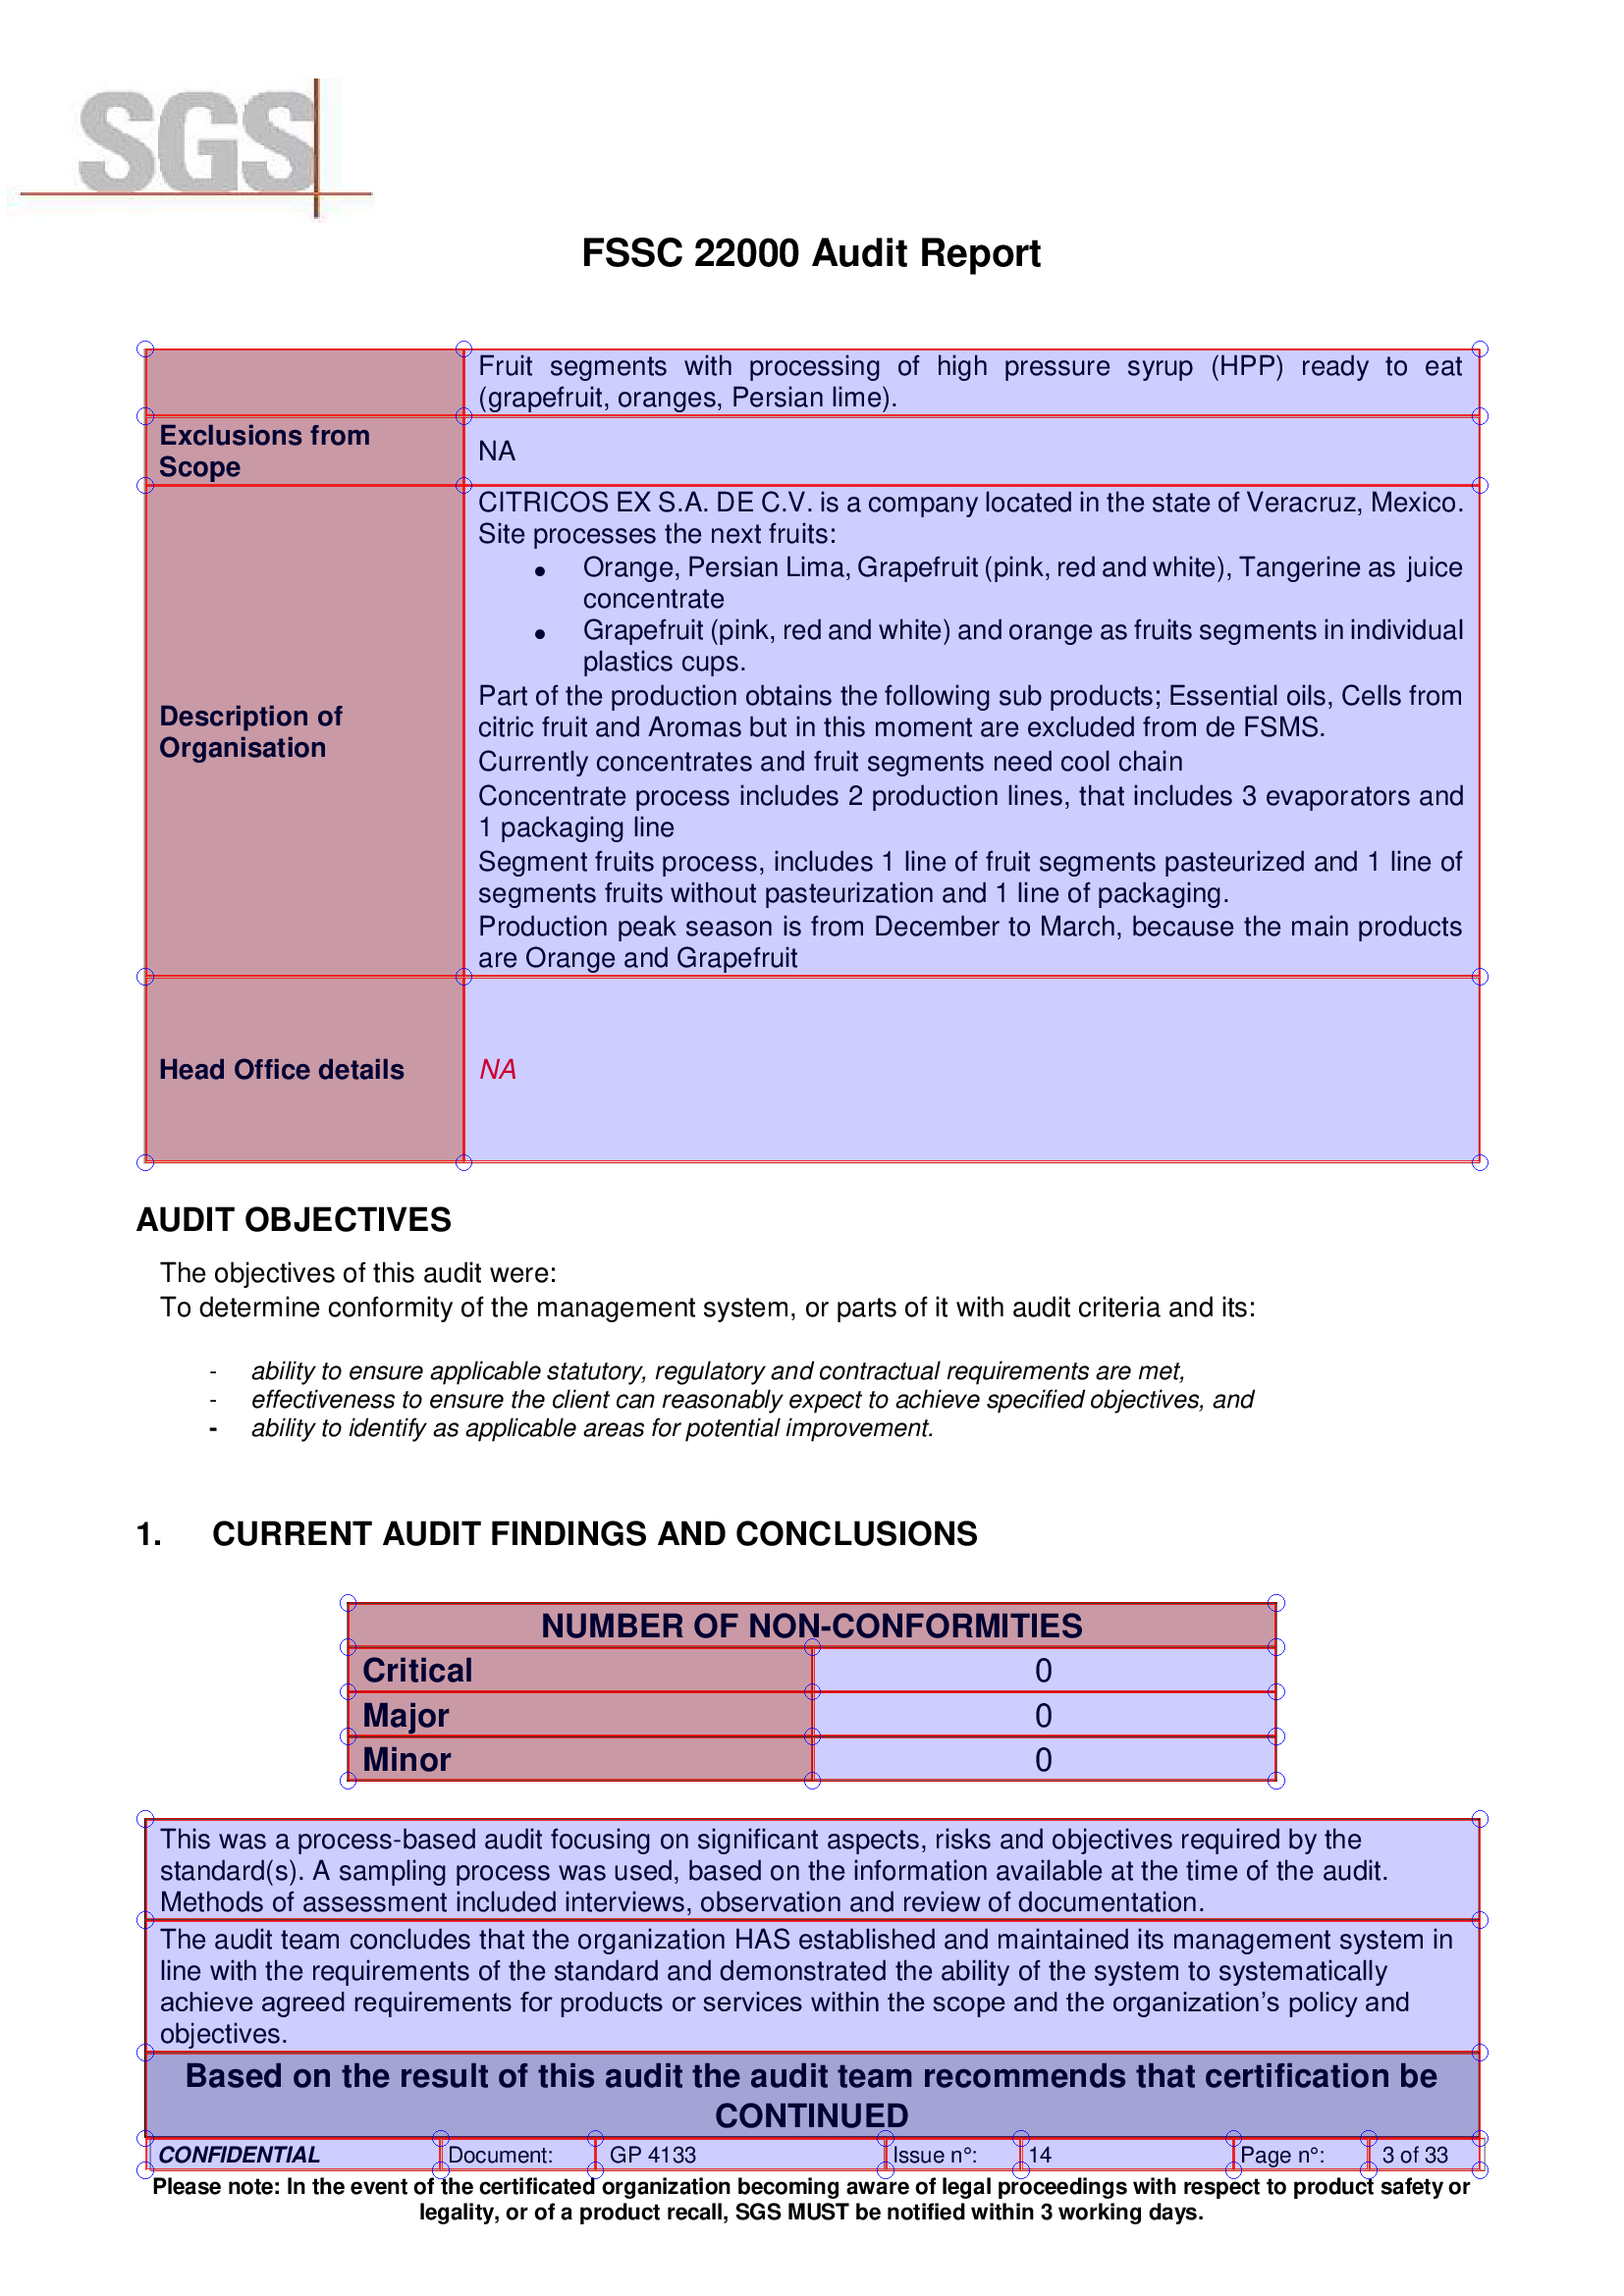

time: 1.86 s (started: 2022-11-30 10:03:39 +00:00)


In [ ]:
from collections import Counter
from collections.abc import Iterable

fpath = all_paths[18]
page_infos = []
page_index = 2
with pdfplumber.open(fpath) as pdf:
  p = pdf.pages[page_index]
  width, height = p.width, p.height
  print(list(map(lambda x: x['non_stroking_color'], p.rects)))
  non_strokings = list(map(lambda x: tuple(x['non_stroking_color']) if isinstance(x['non_stroking_color'], Iterable) else x['non_stroking_color'], p.rects))
  print(non_strokings)
  c = Counter(non_strokings)
  if len(c) > 0 and len(p.rects) > 30:
    n = 1
    temp = sorted(c.values())[::-1]
    for i in temp[1:]:
      if temp[0] / i < 2 and i > 10: n += 1
    mode_value = list(map(lambda x: x[0], c.most_common(n)))
    filter_fn = keep_visible_lines(mode_value)

    p = p.filter(filter_fn)

  ts = {
    "vertical_strategy": "lines",
    "horizontal_strategy": "lines",
  }

  tables = list(map(lambda x: x.bbox, p.find_tables(table_settings=ts)))
  tables = list(map(lambda x: [x[0]/width, x[1]/height, x[2]/width, x[3]/height], tables))
  im = p.to_image(resolution=200)
  debugged = im.debug_tablefinder(ts)
debugged

In [ ]:
images = list(map(lambda x: cv2.cvtColor(np.array(x), cv2.COLOR_RGB2BGR), convert_from_path(fpath)))
image = images[page_index]

viz_img = image.copy()
cropped_tables = []
for x1,y1,x2,y2 in tables:
  h, w = viz_img.shape[:2]
  x1, y1 = int(x1*w), int(y1*h)
  x2,y2 = int(x2*w), int(y2*h)
  cv2.rectangle(viz_img, (x1,y1), (x2,y2), (0,0,255), 5)
  cropped_tables += [ image[y1-30:y2+30, x1-30:x2+30] ]


time: 6.23 s (started: 2022-11-30 15:37:07 +00:00)


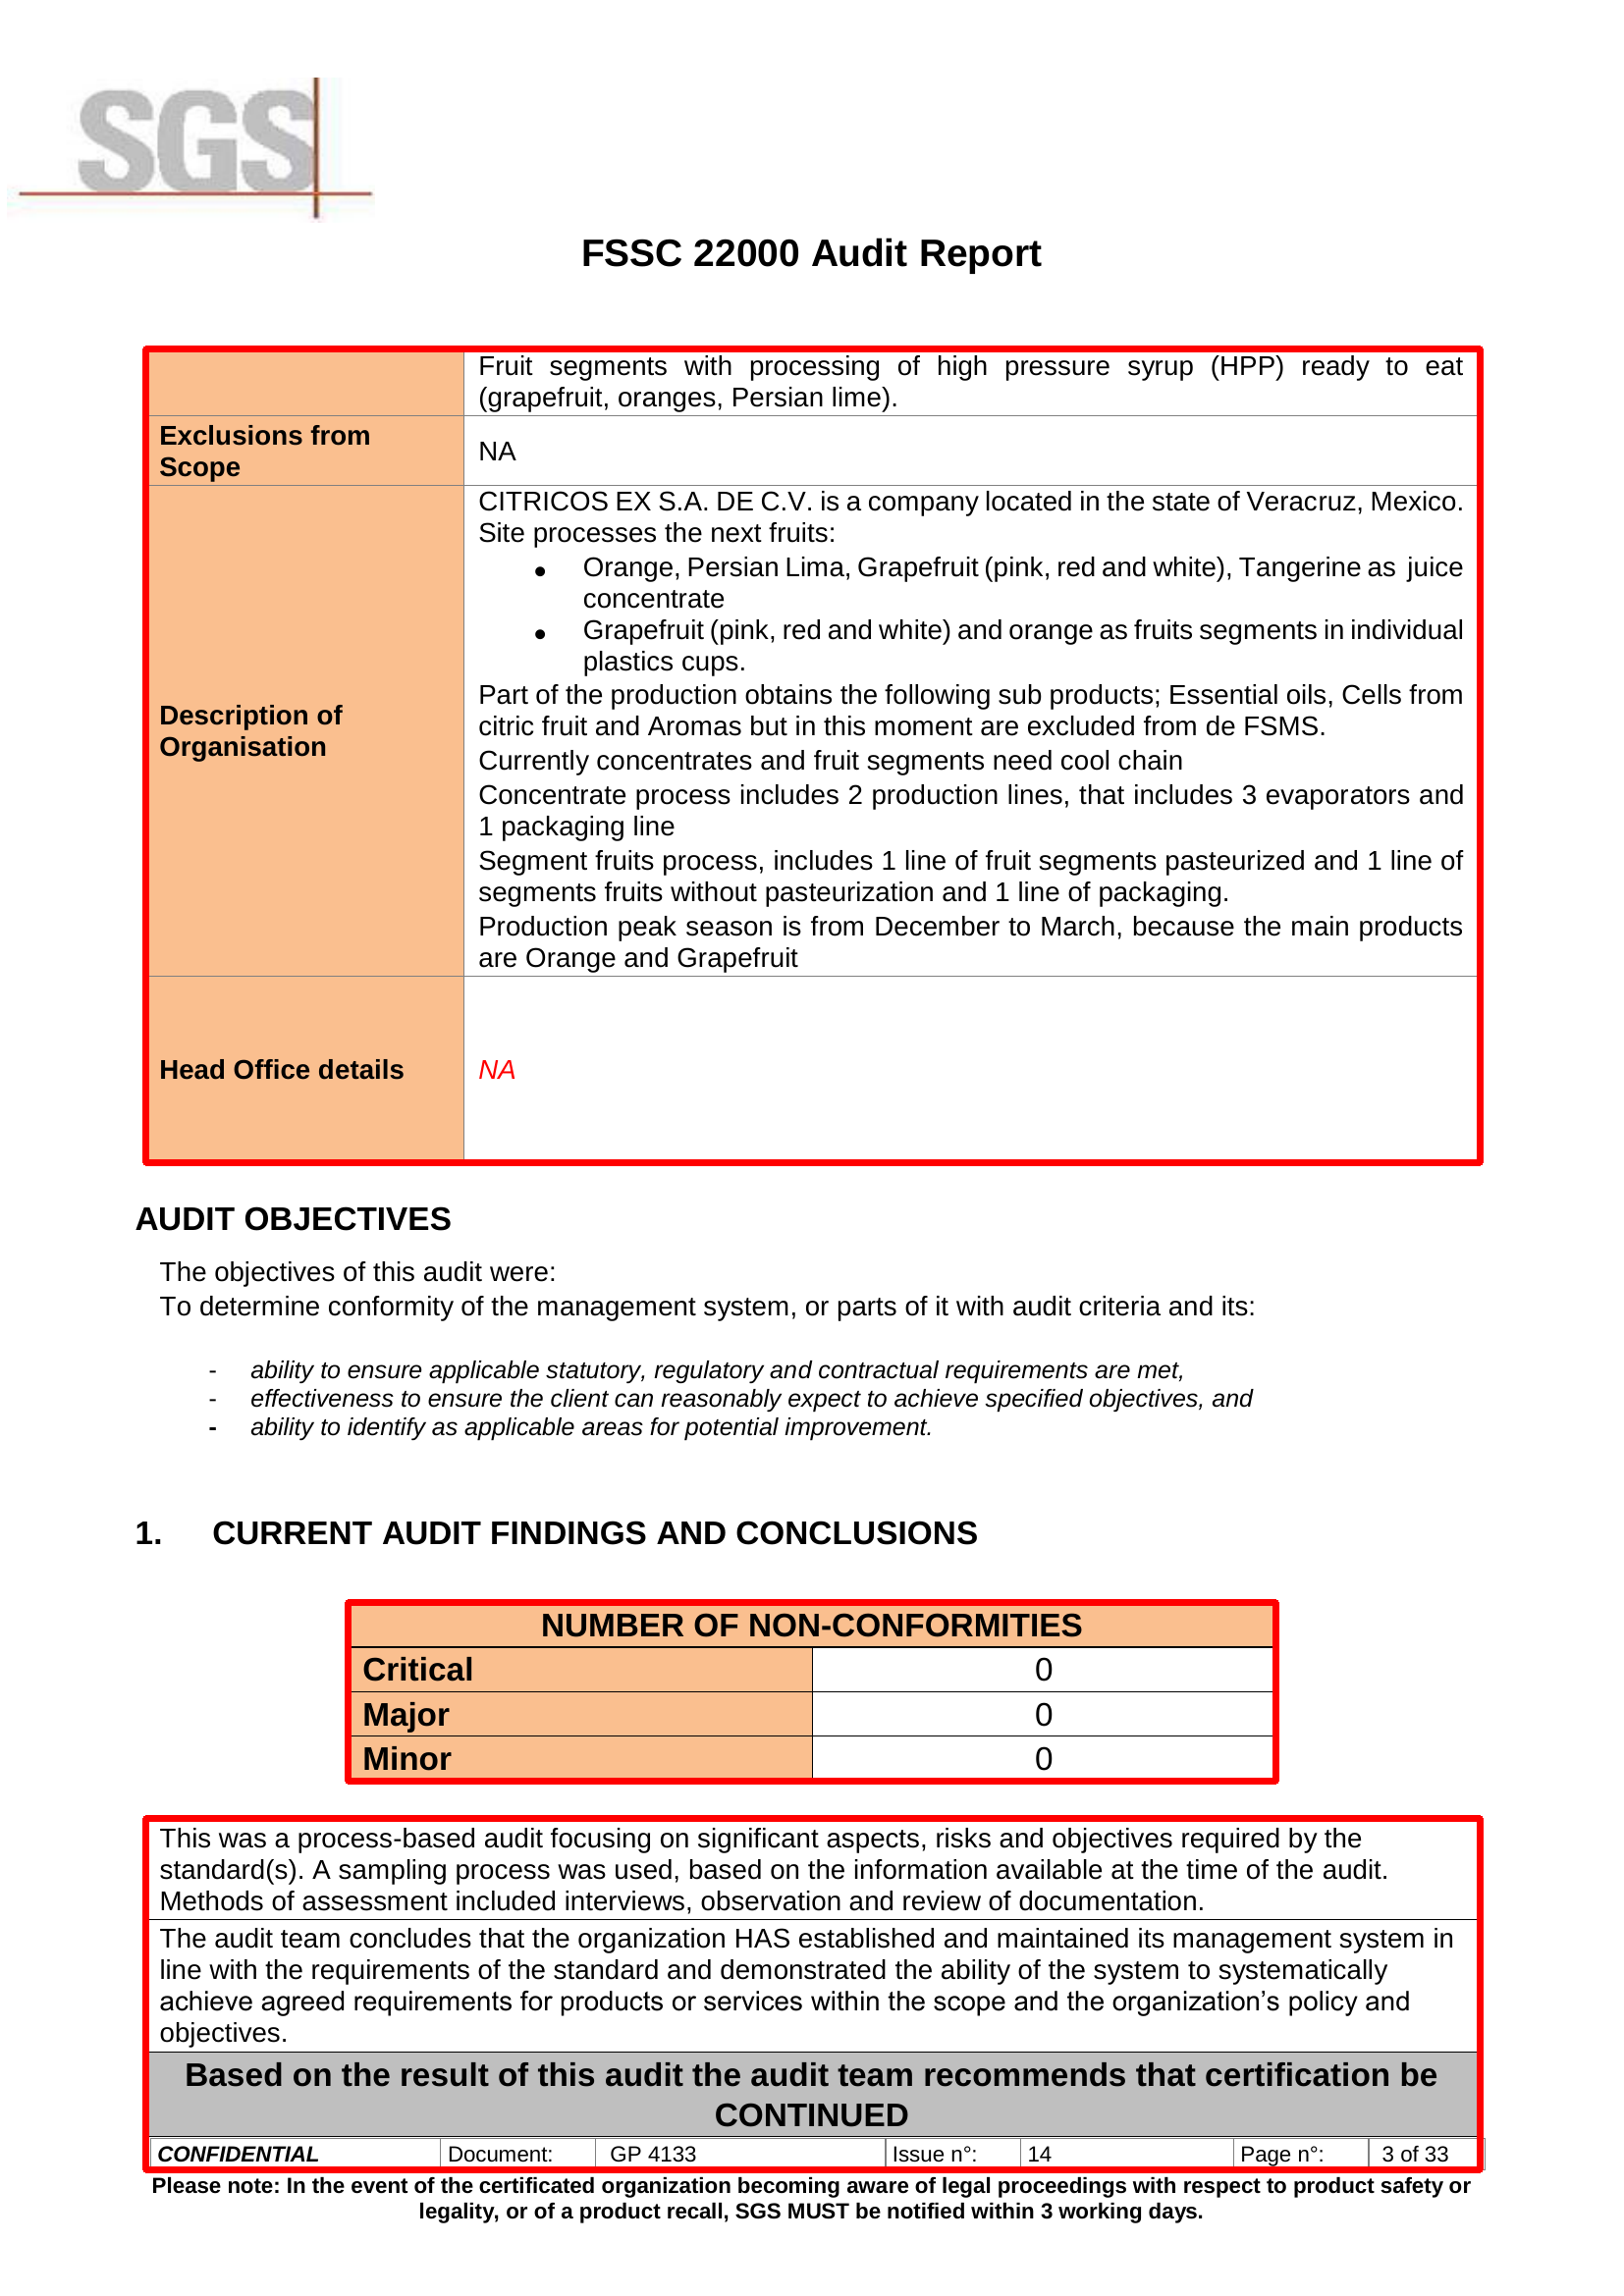

time: 298 ms (started: 2022-11-30 15:37:17 +00:00)


In [ ]:
cv2_imshow(viz_img)

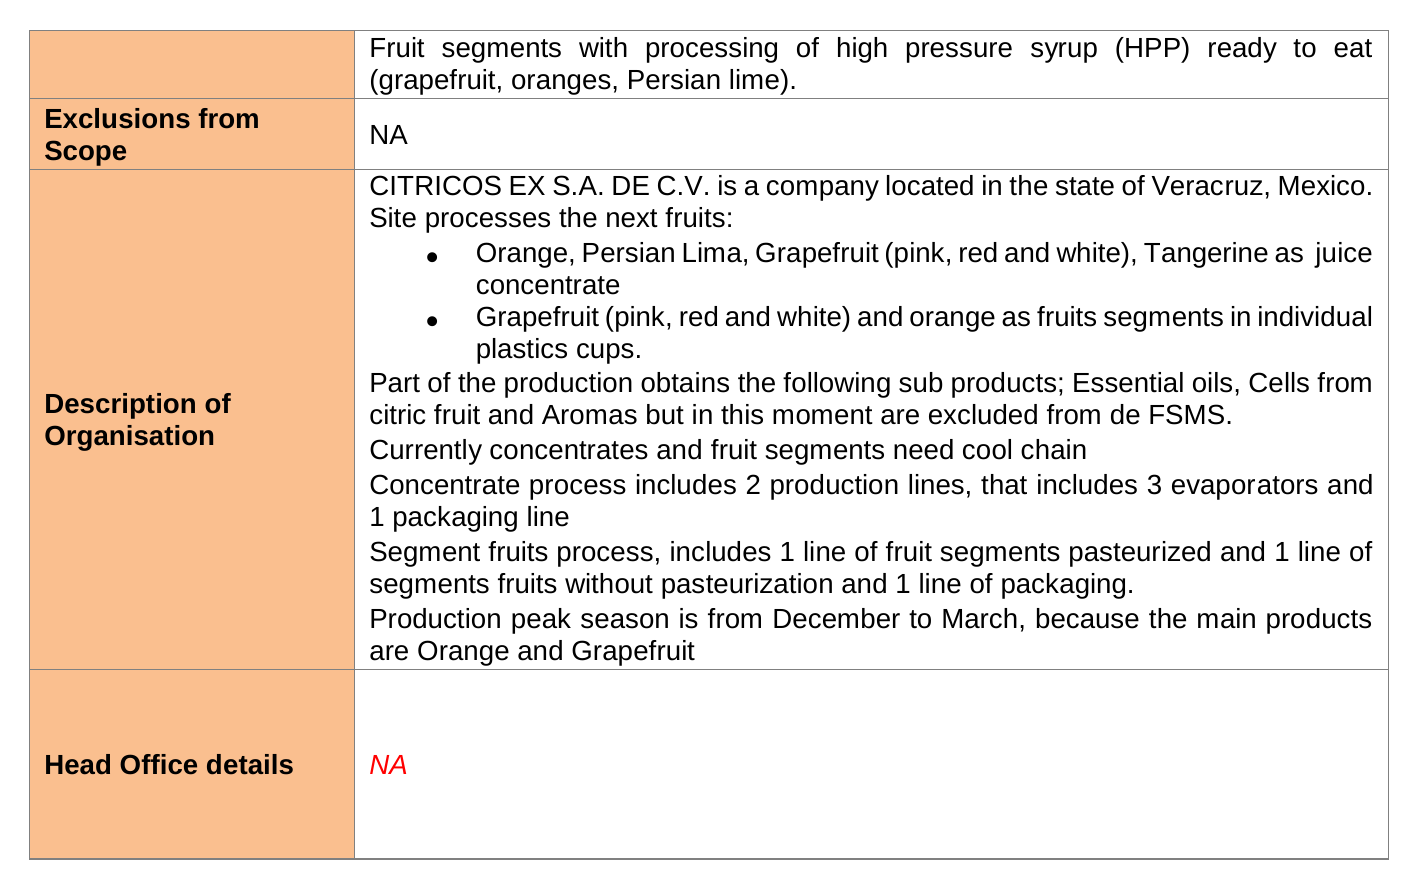

time: 109 ms (started: 2022-11-30 15:37:19 +00:00)


In [ ]:
cv2_imshow(cropped_tables[0])

In [ ]:
cv2.imwrite('imae.jpg', cropped_tables[1])

True

time: 40.2 ms (started: 2022-11-30 17:14:10 +00:00)


### <hr>

### Table structure recognition with Table tranformer

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q timm

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 182 kB 7.7 MB/s 
     |████████████████████████████████| 7.6 MB 44.7 MB/s 
time: 42.7 s (started: 2022-11-30 10:24:16 +00:00)


In [ ]:
# from huggingface_hub import hf_hub_download
# from PIL import Image

# file_path = hf_hub_download(repo_id="nielsr/example-pdf", repo_type="dataset", filename="example_table.png")
# image = Image.open(file_path).convert("RGB")
# width, height = image.size
# image.resize((int(width*0.5), int(height*0.5)))

In [ ]:
from transformers import DetrFeatureExtractor
from transformers import TableTransformerForObjectDetection

feature_extractor = DetrFeatureExtractor()
model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-structure-recognition")

time: 1 s (started: 2022-11-30 10:55:27 +00:00)


In [ ]:
import matplotlib.pyplot as plt

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results(pil_img, scores, labels, boxes):
    plt.figure(figsize=(32,20))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for score, label, (xmin, ymin, xmax, ymax),c  in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{model.config.id2label[label]}: {score:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

time: 5.03 ms (started: 2022-11-30 10:55:35 +00:00)


In [ ]:
image = cropped_tables[0]
encoding = feature_extractor(image, return_tensors="pt")
encoding.keys()

dict_keys(['pixel_values', 'pixel_mask'])

time: 107 ms (started: 2022-11-30 10:55:45 +00:00)


In [ ]:
import torch
with torch.no_grad():
  outputs = model(**encoding)

time: 2.7 s (started: 2022-11-30 10:55:48 +00:00)


In [ ]:
target_sizes = [image.shape[:2][::-1]]
results = feature_extractor.post_process_object_detection(outputs, threshold=0.6, target_sizes=target_sizes)[0]
# plot_results(image, results['scores'], results['labels'], results['boxes'])

time: 5.66 ms (started: 2022-11-30 10:57:44 +00:00)


In [ ]:
viz_img = image.copy()
for (x1,y1,x2,y2), score, label in zip(results['boxes'].tolist(), results['scores'].tolist(), results['labels'].tolist()):
  if label != 1 : continue
  x1, y1, x2, y2 = np.asanyarray([x1, y1,x2,y2]).astype(int)
  cv2.rectangle(viz_img, (x1,y1), (x2,y2), (0,0,255), 1)
  cv2.putText(viz_img, f'{model.config.id2label[label]}', (x1,y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (15,82,74))

time: 27.1 ms (started: 2022-11-30 14:49:06 +00:00)


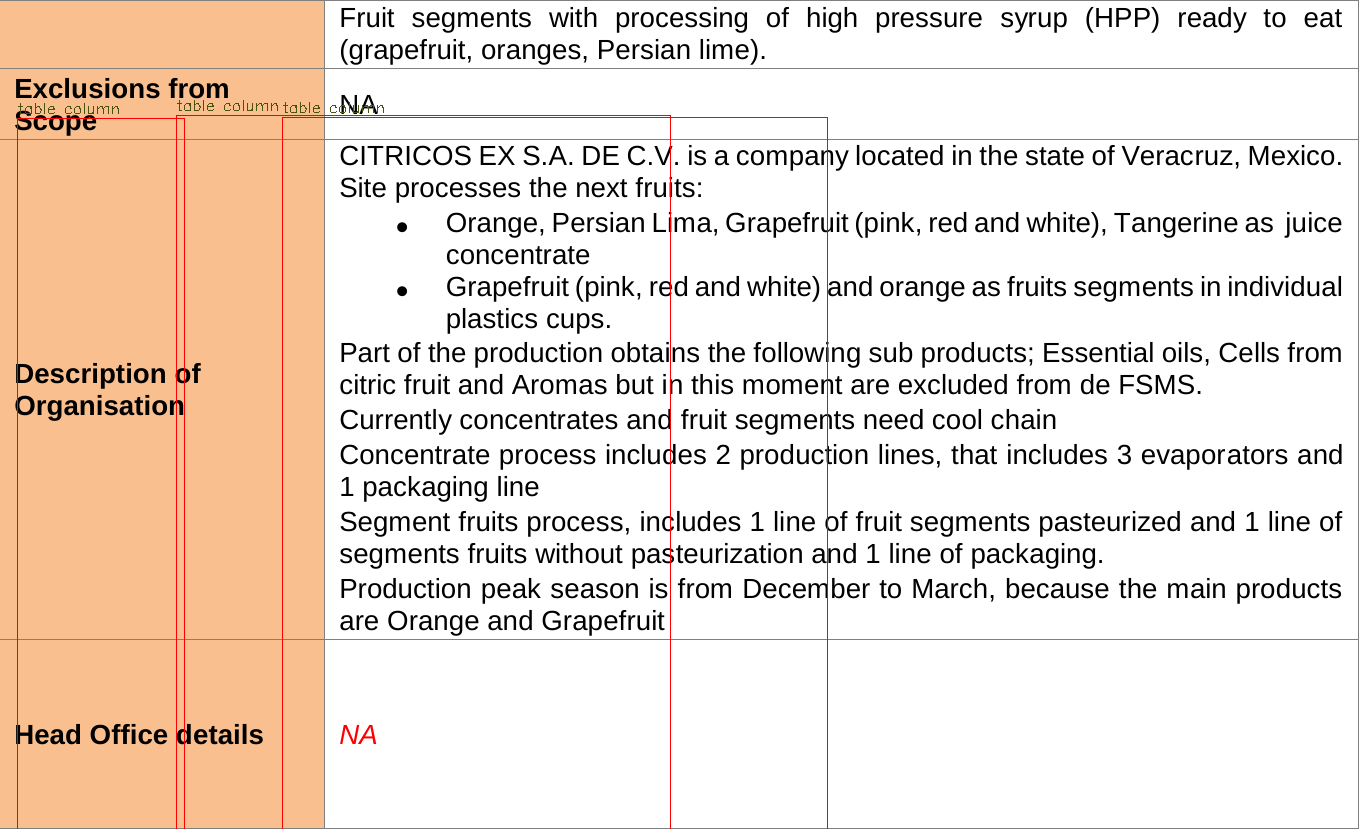

time: 170 ms (started: 2022-11-30 14:49:07 +00:00)


In [ ]:
cv2_imshow(viz_img)

In [ ]:
[results['labels']]

tensor([2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 3, 0])

time: 12.6 ms (started: 2022-11-30 10:58:03 +00:00)


In [ ]:
from PIL import Image

time: 1.09 ms (started: 2022-11-30 14:52:38 +00:00)


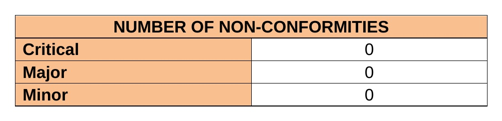

time: 34.2 ms (started: 2022-11-30 17:14:23 +00:00)


In [ ]:
image = Image.open('/content/imae.jpg').convert("RGB")
# image = Image.open(file_path).convert("RGB")
width, height = image.size
image = image.resize((int(width*0.5), int(height*0.5)))
image

In [ ]:
image.size

(502, 121)

time: 6.09 ms (started: 2022-11-30 17:14:24 +00:00)


In [ ]:
encoding = feature_extractor(image, return_tensors="pt")
encoding.keys()

with torch.no_grad():
  outputs = model(**encoding)

time: 1.58 s (started: 2022-11-30 17:14:24 +00:00)


In [ ]:
import matplotlib.pyplot as plt

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results(pil_img, scores, labels, boxes):
    plt.figure(figsize=(32,20))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for score, label, (xmin, ymin, xmax, ymax),c  in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
        if label !=5: continue
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{model.config.id2label[label]}: {score:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

time: 10.4 ms (started: 2022-11-30 17:15:28 +00:00)


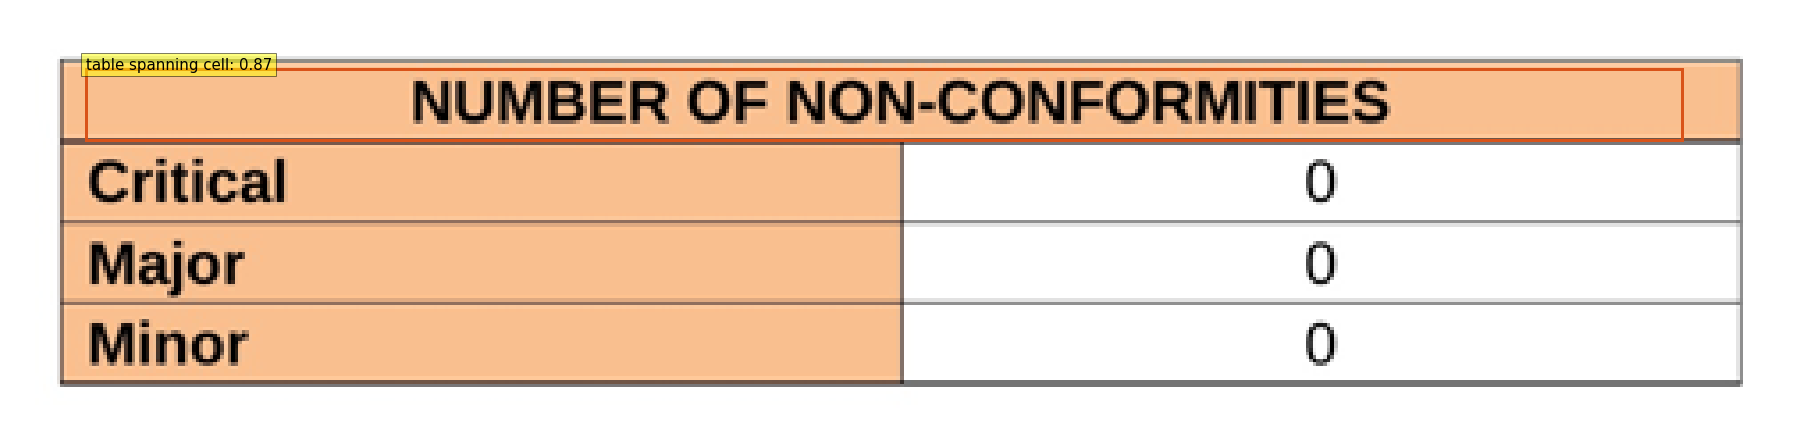

time: 420 ms (started: 2022-11-30 17:15:28 +00:00)


In [ ]:
target_sizes = [image.size[::-1]]
results = feature_extractor.post_process_object_detection(outputs, threshold=0.6, target_sizes=target_sizes)[0]
plot_results(image, results['scores'], results['labels'], results['boxes'])

In [ ]:
from huggingface_hub import hf_hub_download
from PIL import Image

file_path = hf_hub_download(repo_id="nielsr/example-pdf", repo_type="dataset", filename="example_table.png")

time: 368 ms (started: 2022-11-30 15:49:55 +00:00)


In [ ]:
encoding.pixel_mask

tensor([[[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]]])

time: 22.3 ms (started: 2022-11-30 15:09:35 +00:00)


In [ ]:
model.config.id2label

{0: 'table',
 1: 'table column',
 2: 'table row',
 3: 'table column header',
 4: 'table projected row header',
 5: 'table spanning cell'}

time: 7.96 ms (started: 2022-11-30 15:48:39 +00:00)


In [ ]:
def get_bbox_of_page(page):
  '''
  OCR on pdf page file:
  Input:
    page read from plumber
  Return
    list of all words
    numpy array of normalize bounding boxes (in range 0,1) in order (x1,y1,x2,y2)
  '''
  words = []
  bboxes = [] 
  height, width = page.height, page.width
  extract_result = page.dedupe_chars().extract_words(x_tolerance=1, y_tolerance=2)
  for bbox in extract_result:
    words += [ bbox['text'] ]
    bboxes += [ [bbox['x0']/width, bbox['top']/height, bbox['x1']/width, bbox['bottom']/height] ]
  
  return words, np.array(bboxes)

def extract_pdf_file(filepath):
  '''
  Extract images, list of words, list of bbox from pdf file path
  Input:
    filepath: path to pdf file
  Output:
    list of all page images
    list of words for each page
    list of bbox for each page
  '''
  file_images = list(map(lambda x: cv2.cvtColor(np.array(x), cv2.COLOR_BGR2RGB), convert_from_path(filepath)))
  file_words = []
  file_bboxes = []

  with pdfplumber.open(filepath) as pdf:
    assert len(pdf.pages) == len(file_images), 'Error in converting pdf to image'
    for page in pdf.pages:
      words, bboxes = get_bbox_of_page(page)
      file_words += [words]
      file_bboxes += [bboxes]
  return file_images, file_words, file_bboxes 

time: 3.99 ms (started: 2022-12-01 03:52:07 +00:00)


In [ ]:
pdf_path = all_paths[10]
file_images, file_words, file_bboxes  = extract_pdf_file(pdf_path)

print(pdf_path)

/content/drive/MyDrive/OCR NLP Stage 2/FSSC/Documents/Audit Reports/LR/unreadable/FSSC Audit Report-2019.pdf
time: 11.2 s (started: 2022-12-01 14:51:55 +00:00)


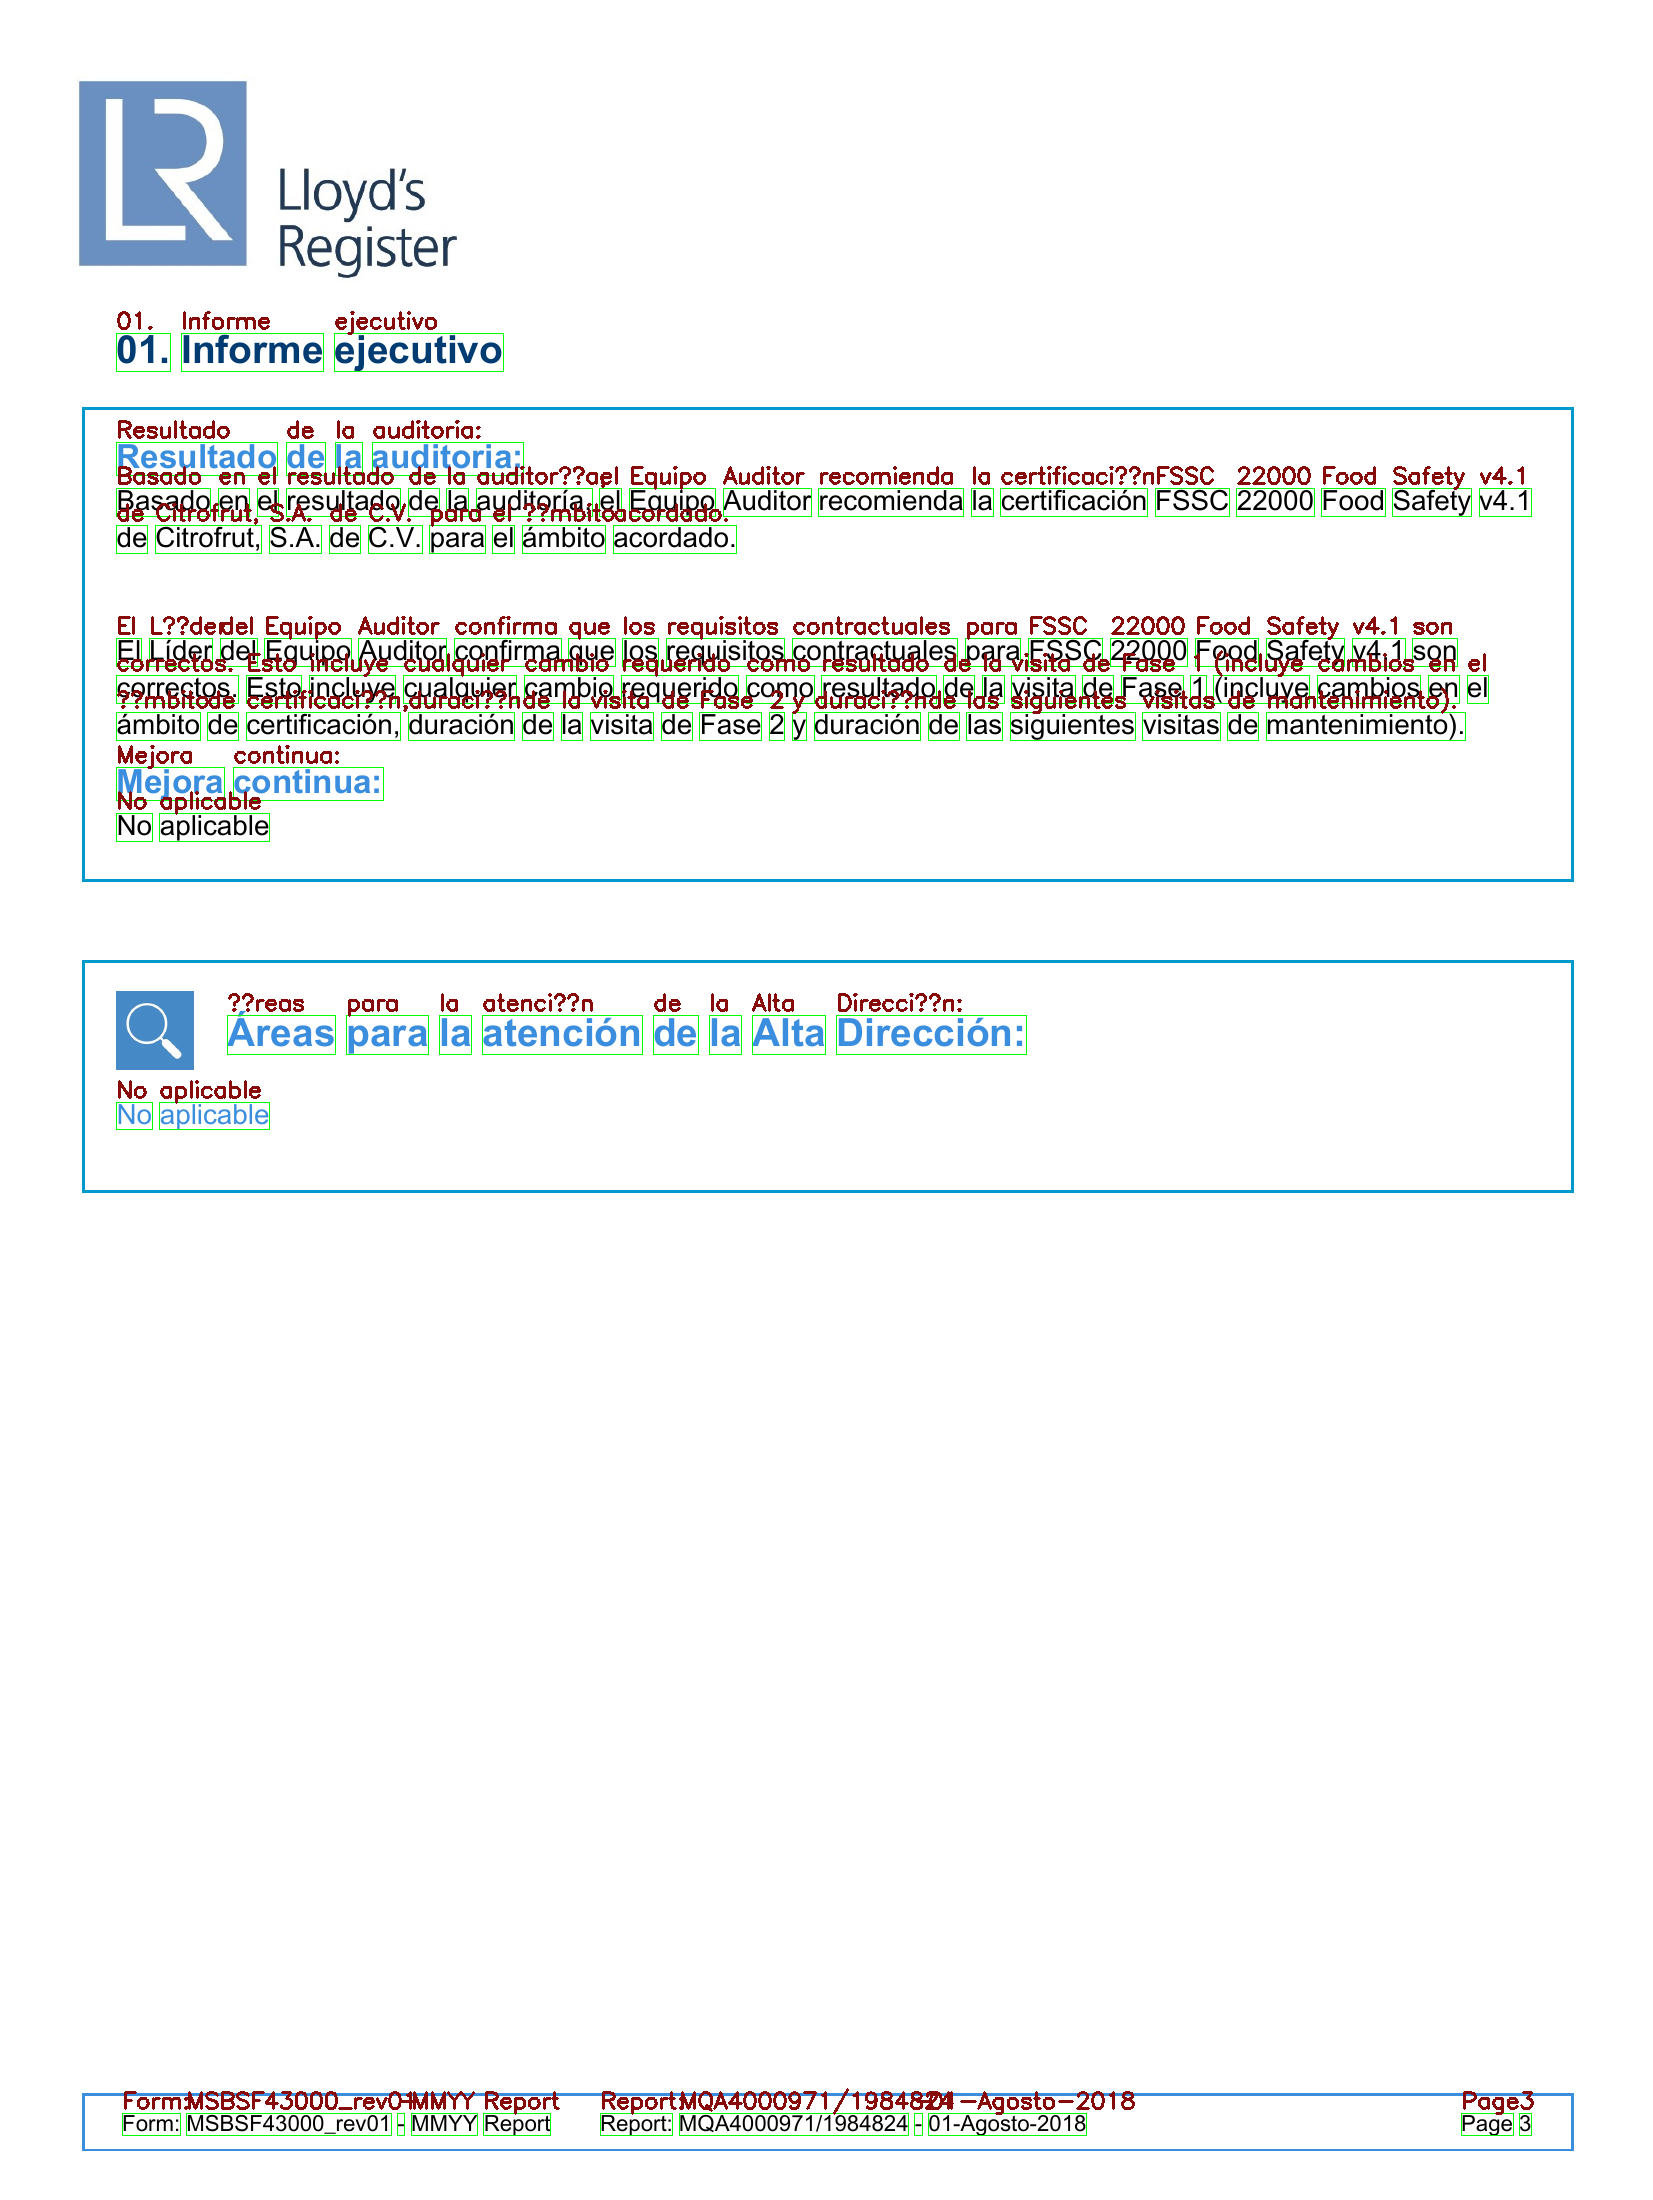

time: 221 ms (started: 2022-12-01 14:52:07 +00:00)


In [ ]:
page_idx = 2

page_image = file_images[page_idx].copy()
page_words = file_words[page_idx].copy()
page_bboxes = file_bboxes[page_idx].copy()
h, w = page_image.shape[:2]

page_bboxes[:, (0,2)] = page_bboxes[:, (0,2)] * w
page_bboxes[:, (1,3)] = page_bboxes[:, (1,3)] * h
page_bboxes = page_bboxes.astype(np.int32)

viz_img = page_image.copy()
for (x1,y1,x2,y2), word in zip(page_bboxes, page_words):
  
  cv2.rectangle(viz_img, (x1,y1), (x2,y2), (0,255,0), 1)
  cv2.putText(viz_img, word, (x1,y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.75, [11,11,135], 2)

cv2_imshow(viz_img)

In [ ]:
tables = []
with pdfplumber.open(all_paths[30]) as pdf:
  for page_id, page in enumerate(pdf.pages):
    page_tables = page.find_tables()
    tables += page_tables

tables = list(map(lambda table: pd.DataFrame(table.extract()).fillna(''), tables))

time: 8.57 s (started: 2022-12-01 04:11:18 +00:00)


In [ ]:
len(tables)

0

time: 5.15 ms (started: 2022-12-01 04:11:34 +00:00)
